<a href="https://colab.research.google.com/github/jnsbrdbr/thesis/blob/thesis/part3_Gaussian_Svm_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [3]:
with pd.HDFStore('/content/drive/MyDrive/1000/part2_result',  mode='r') as newstore:
    result = newstore.select('result')

In [4]:
print(result)

             0         1         2  ...         8         9  label
0    -1.680599 -3.061217 -0.040984  ... -0.006112 -0.004759      1
1    -1.680599 -3.061217 -0.040984  ... -0.006112 -0.004759      1
2    -1.680599 -3.061217 -0.040984  ... -0.006112 -0.004759      1
3    -1.680599 -3.061217 -0.040984  ... -0.006112 -0.004759      1
4    -1.680599 -3.061217 -0.040984  ...  0.006186  0.002988      1
...        ...       ...       ...  ...       ...       ...    ...
1315 -1.680599 -3.061217 -0.040984  ... -0.035323 -0.015205      0
1316 -1.680599 -3.061217 -0.040984  ... -0.012077 -0.016767      0
1317 -1.680599 -3.061217 -0.040984  ... -0.011761 -0.013474      0
1318 -1.680599 -3.061217 -0.040984  ...  0.004503  0.113459      0
1319 -1.680599 -3.061217 -0.040984  ... -0.022880  0.001418      0

[1320 rows x 71 columns]


In [5]:
import copy
result_nonlabel=copy.deepcopy(result)
del result_nonlabel['label']
X=result_nonlabel
y=result.label

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)

In [7]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF(1.0)
k=GaussianProcessClassifier(kernel=kernel,random_state=42)
gpc = k.fit(x_train, y_train)

In [8]:
predictions = gpc.predict(x_test)
score = gpc.score(x_test, y_test)
print(score)

0.9949494949494949


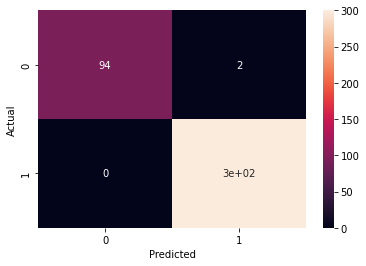

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

confusion_matrix = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [10]:
print('Accuracy: ',metrics.accuracy_score(y_test, predictions))

Accuracy:  0.9949494949494949


In [11]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


cv = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(k, x_train, y_train, scoring='accuracy', cv=cv,n_jobs=-1)

print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.981 (0.009)


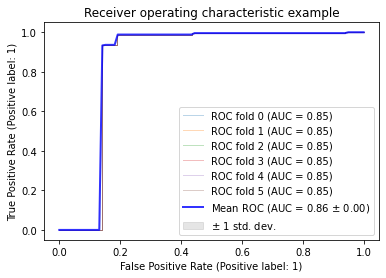

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold


random_state = np.random.RandomState(0)
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel="rbf", probability=True, random_state=random_state)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(x_train, y_train)
    viz = RocCurveDisplay.from_estimator(
        classifier,
        x_train,
        y_train,
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

In [13]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,predictions)

0.9895833333333333

In [14]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,cross_val_predict


cv = KFold(n_splits=10, random_state=42, shuffle=True)
scores_recall = cross_val_score(k,x_train, y_train, scoring='recall', cv=cv,n_jobs=-1)
cv_predicts_10_folds = cross_val_predict(k,x_train, y_train,cv=cv,n_jobs=-1)
print('scores_recall: %.3f (%.3f)' % (mean(scores_recall), std(scores_recall)))
print('cv_predicts_10_folds: %.3f (%.3f)' % (mean(cv_predicts_10_folds), std(cv_predicts_10_folds)))

scores_recall: 0.988 (0.023)
cv_predicts_10_folds: 0.748 (0.434)


In [15]:
scores_recall

array([1.        , 1.        , 1.        , 1.        , 0.98591549,
       0.97058824, 1.        , 1.        , 1.        , 0.92537313])

In [16]:
FNR=1-(scores_recall)
print(FNR)

[0.         0.         0.         0.         0.01408451 0.02941176
 0.         0.         0.         0.07462687]


In [17]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


cv = KFold(n_splits=10, random_state=42, shuffle=True)
scores_precision = cross_val_score(k, x_train, y_train, scoring='precision', cv=cv,n_jobs=-1)

print('scores_precision: %.3f (%.3f)' % (mean(scores_precision), std(scores_precision)))

scores_precision: 0.987 (0.012)
